# ROI detection with Deep Learning
Notebook used to test ROI detection using Deep Learning with PyTorch.

In [1]:
%matplotlib inline

import os, sys, time, shutil
import random
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
import imgaug.augmenters as iaa

import torch

# Add parent folder to path in order to access `axoid`
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from axoid.utils.image import imread_to_float, to_npint, overlay_mask, overlay_preds_targets
from axoid.detection.deeplearning.data import normalize_range, get_all_dataloaders, get_filenames, \
                                              pad_transform, pad_transform_stack
from axoid.detection.deeplearning.loss import get_BCEWithLogits_loss
from axoid.detection.deeplearning.metric import get_dice_metric, get_crop_dice_metric
from axoid.detection.deeplearning.model import CustomUNet, load_model
from axoid.detection.deeplearning.train import train, train_plot
from axoid.detection.deeplearning.test import predict, predict_stack, evaluate, show_sample

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


## Parameters
Hyperparameters, folder names, etc.

In [2]:
n_epochs = 4
batch_size = 16
learning_rate = 0.0005
step_decay = 5 # Number of epochs after which the lr is decayed by a factor 2 (None for no decay)

use_crop_dice = False
crop_dice_scale = 4.0 # scale of the cropping (w.r.t. ROI's bounding box) for the dice coef.

use_weights = True # if False use class weights, if True use pixelwise weights (if existing)

synth_data = True
synth_ratio = None # ratio of synthetic data vs. real data
only_synth = False # If True, will use only the synthetic data (and all of it, at the opposite of ratio=1)

data_aug = True # If True, will use data augmentation (see below for augmentation sequence)

input_channels = "RG" # Channel to use as input
u_depth = 4
out1_channels = 16

model_name = "test"
model_dir = "../data/models/"
data_dir = "/data/talabot/datasets/datasets_190510/"

## Data loading
Create dataloaders, and build data-related constants.

In [3]:
test_dataloader = False

# Create random augment sequence for data augmentation
if data_aug:
    seq = iaa.Sequential([
        iaa.GammaContrast((0.7, 1.3)) # Gamma correction
    ])
    aug_fn = seq.augment_image
    print("Data augmentation is enabled.")
else:
    aug_fn = lambda x: x # identity function

# Create dataloaders
dataloaders = get_all_dataloaders(
    data_dir,
    batch_size, 
    input_channels = input_channels,
    test_dataloader = test_dataloader,
    use_weights = use_weights,
    synthetic_data = synth_data, synthetic_ratio = synth_ratio, synthetic_only = only_synth,
    train_transform = lambda img: normalize_range(pad_transform(aug_fn(img), u_depth)), # With possible augmentation
    train_target_transform = lambda img: pad_transform(img, u_depth),
    eval_transform = lambda img: normalize_range(pad_transform(img, u_depth)), 
    eval_target_transform = lambda img: pad_transform(img, u_depth)
)

N_TRAIN = len(dataloaders["train"].dataset)
N_VALID = len(dataloaders["valid"].dataset)
if test_dataloader:
    N_TEST = len(dataloaders["test"].dataset)
    print("%d images:" % (N_TRAIN + N_VALID + N_TEST))
else:
    print("%d images:" % (N_TRAIN + N_VALID))
print("%d to train" % N_TRAIN, end="")
if only_synth:
    print(" (of synthetic data only).")
elif synth_data:
    if synth_ratio is None:
        print(" (with synthetic data)")
    else:
        print(" (with %d%% of synthetic data)" % (synth_ratio * 100))
else:
    print("")
print("%d to validation" % N_VALID)
if test_dataloader:
    print("%d to test" % N_TEST)

# Compute class weights (as pixel imbalance) takes ~90s for 78 stacks
if use_weights:
    print("Pixel-wise weighting enabled")
pos_count = 0
neg_count = 0
for filename in dataloaders["train"].dataset.y_filenames:
    y = io.imread(filename)
    pos_count += (y == 255).sum()
    neg_count += (y == 0).sum()
pos_weight = torch.tensor((neg_count + pos_count) / (2 * pos_count)).to(device)
neg_weight = torch.tensor((neg_count + pos_count) / (2 * neg_count)).to(device)
print("{} ROI pixels, and {} background".format(pos_count, neg_count))
print("  --> {:f} positive weighting".format(pos_weight))
print("  --> {:f} negative weighting".format(neg_weight))

Data augmentation is enabled.
25421 images:
18506 to train (with synthetic data)
6915 to validation
Pixel-wise weighting enabled
10169048 ROI pixels, and 1165071656 background
  --> 57.785187 positive weighting
  --> 0.504364 negative weighting


## Model definition
Define model, loss, metrics, and optimizer.

In [4]:
model = CustomUNet(len(input_channels), u_depth=u_depth, 
                   out1_channels=out1_channels, batchnorm=True, device=device)
print(model)
# (Optional) load weights from existing model
# model.load_state_dict(torch.load("models/unet4-16_RG_cv-annotated_aug/model_best.pth"))

# Save the "architecture" of the model by copy/pasting the class definition file
os.makedirs(os.path.join(model_dir, model_name), exist_ok=True)
shutil.copy("../axoid/detection/deeplearning/model.py", os.path.join(model_dir, model_name, "utils_model_save.py"))

loss_fn = get_BCEWithLogits_loss(pos_weight=pos_weight, neg_weight=neg_weight)

metrics = {"dice": get_dice_metric()}
if use_crop_dice:
    metrics.update({"diC%.1f"%crop_dice_scale: get_crop_dice_metric(scale=crop_dice_scale)})

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if step_decay is not None:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_decay, gamma=0.5)
else:
    scheduler = None

CustomUNet(
  (activation): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UNetConv(
      (activation): ReLU()
      (co

## Training

In [5]:
best_model, history = train(model,
                            dataloaders,
                            loss_fn,
                            optimizer,
                            n_epochs,
                            scheduler = scheduler,
                            metrics = metrics,
                            criterion_metric = "dice",
                            model_dir = os.path.join(model_dir, model_name),
                            replace_dir = True,
                            verbose = 1)

Epoch 0/0  (Elapsed time: 0h 00min 00s)
---------------------------------------
Batch (over 1157): 1...115...230...345...460...575...690...805...920...1035...1150...
Train loss: 0.250581 - dice: 0.682301
Valid loss: 0.406170 - dice: 0.778269

Training took 0h 10min 04s.
Best validation dice = 0.778 at epoch 0.
According validation loss = 0.406


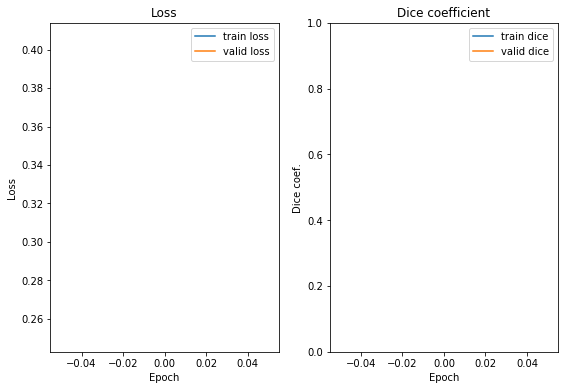

In [6]:
fig = train_plot(history, crop_dice=use_crop_dice, scale_crop=crop_dice_scale)
fig.show()

## Testing
Test and visualize best model on valid/test data. Note that this is for debugging purposes: you should use the test data only at the very end! Otherwise, just use validation data.

In [7]:
# Load best model
name_test = "190510_aug_synth"
# name_test = "RG_synth_190311"
# name_test = "unet4-16_RG_cv-annotated_aug"
# name_test = "unet4-16_synth_only_2-6neur_181205"

best_model = load_model(os.path.join(model_dir, name_test), input_channels=input_channels, 
                        u_depth=u_depth, out1_channels=out1_channels, device=device)
best_model.eval()

CustomUNet(
  (activation): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convs): ModuleList(
    (0): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UNetConv(
      (activation): ReLU()
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UNetConv(
      (activation): ReLU()
      (co

In [8]:
# Evaluate over a dataloader
ev_metrics = evaluate(best_model, dataloaders["valid"], 
                        {"loss": loss_fn, **metrics})
print("Loss = {}\nDice = {}".format(ev_metrics["loss"], ev_metrics["dice"]) + \
      ("\nDiC{:.1f} = {}".format(crop_dice_scale, ev_metrics["diC%.1f"%crop_dice_scale]) if use_crop_dice else ""))

Loss = 0.3187908080355981
Dice = 0.8324109363538669


Image   2327 (/data/talabot/datasets/datasets_190510/validation/MDN1-5_imaging_MDN1_fly2_012/rgb_frames/rgb_0477.png): 
dice = 0.818086 - 
Image   2347 (/data/talabot/datasets/datasets_190510/validation/MDN1-5_imaging_MDN1_fly2_012/rgb_frames/rgb_0497.png): 
dice = 0.887902 - 
Image   3234 (/data/talabot/datasets/datasets_190510/validation/SS25478_20190227_tdTomGC6fopt-fly2_002/rgb_frames/rgb_0587.png): 
dice = 0.779783 - 
Image   3722 (/data/talabot/datasets/datasets_190510/validation/SS28596_20190326_tdTomGC6fopt-fly2_001/rgb_frames/rgb_0008.png): 
dice = 0.941046 - 


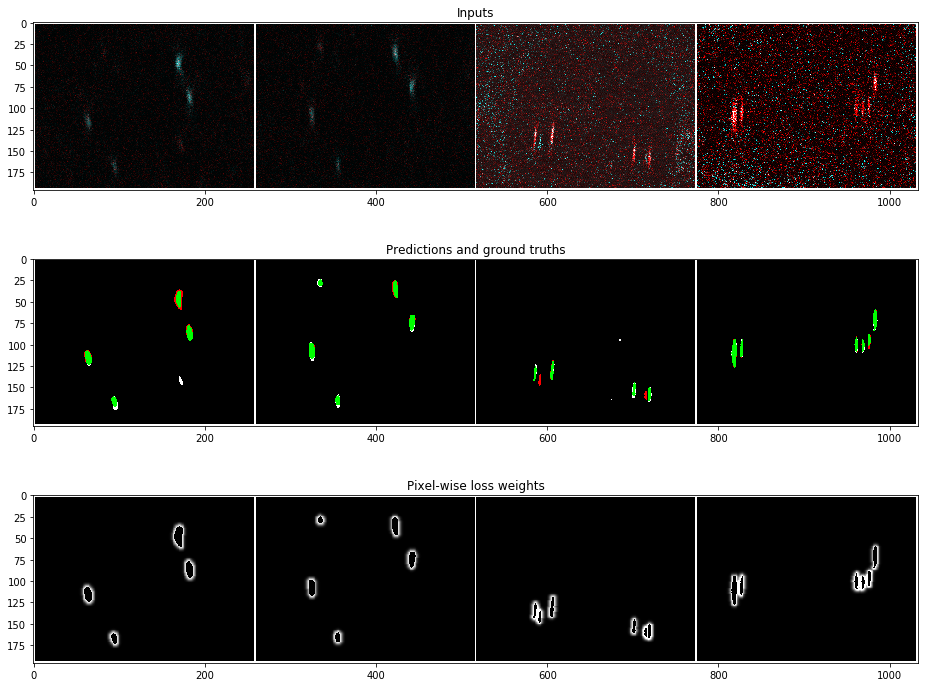

In [9]:
show_sample(best_model, dataloaders["valid"], n_samples=4, metrics=metrics)

### Test on a full stack

In [10]:
exp_name = "/data/talabot/experiments/to_annotate/R76B10_20181224_tdTomGC6fopt-fly1/R76B10_20181224_tdTomGC6fopt-fly1_003/"
# exp_name = "/data/talabot/pdm/dataset_cv-annotated/validation_fail/A1_S47-3_fly1_S47_tdTom-GC6s_fly3_011/"
# exp_name = "/mnt/NAS/CLC/Ascending_Project/R13G06/2P/20190117/R13G06-tdTomGC6fopt-fly1/R13G06-tdTomGC6fopt-fly1-001/2Pimg/"
# exp_name = "/data/talabot/datasets/datasets_190510/validation/SS29633_20190416_tdTomGC6fopt-fly1_001/"

rgb_stack = imread_to_float(os.path.join(exp_name, "RGB.tif"))
try:
    seg_stack = imread_to_float(os.path.join(exp_name, "seg_ROI.tif"))
except FileNotFoundError:
    seg_stack = None

### Optional normalization/transform ###
transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))

start_predict = time.time()
predictions = predict_stack(best_model, rgb_stack, batch_size, input_channels=input_channels, transform=transform)
print("Prediction took %.1fs." % (time.time() - start_predict))

if seg_stack is not None:
    print("dice = %.3f" % metrics["dice"](predictions[:len(seg_stack)], torch.from_numpy(seg_stack)))
    if use_crop_dice:
        print("cropped dice = %.3f" % metrics["diC%.1f"%crop_dice_scale](predictions[:len(seg_stack)], torch.from_numpy(seg_stack)))

predictions = torch.sigmoid(predictions)
@interact(num = widgets.IntSlider(min=0, max=len(rgb_stack) - 1, description='image:'))
def plot_stack_img(num=0):
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.title("RGB data")
    plt.imshow(rgb_stack[num])
    plt.subplot(222)
    plt.title("Input")
    if input_channels == "R":
        plt.imshow(rgb_stack[num,...,0], vmin=0, vmax=1, cmap="gray")
    if input_channels == "G":
        plt.imshow(rgb_stack[num,...,1], vmin=0, vmax=1, cmap="gray")
    elif input_channels == "RG":
        plt.imshow(rgb_stack[num], vmin=0, vmax=1)
    plt.subplot(223)
    plt.title("Prediction (max = %.1f)" % predictions[num].max())
    plt.imshow(predictions[num], vmin=0, vmax=1, cmap="gray")
    plt.subplot(224)
    plt.title("Binary reduction")
    plt.imshow(predictions[num] > 0.5, vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.show()
    
    if seg_stack is not None and num < len(seg_stack):
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title("Target")
        plt.imshow(seg_stack[num], cmap="gray")
        plt.subplot(122)
        plt.title("Overlap")
        plt.imshow(overlay_preds_targets((predictions[num] > 0.5).numpy().astype(np.float), seg_stack[num]))
        plt.tight_layout()
        plt.show()

Prediction took 2.1s.


interactive(children=(IntSlider(value=0, description='image:', max=567), Output()), _dom_classes=('widget-inte…